<div align="right" style="text-align: right">
<i>TTK21 lecture 2 - 3D geometry<br>September 2021</i>
</div>

# Exercise 2: Epipolar geometry
We are here given two undistorted images of the Holmenkollen ski jump along with the intrinsic calibration and camera poses.
Lets start by loading the data:

In [84]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Load the images.
img1 = cv2.cvtColor(cv2.imread('holmenkollen_00011.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('holmenkollen_00109.jpg'), cv2.COLOR_BGR2RGB)

# The same camera was used for both images, so we use the same intrinsic calibration for both:
f = 2077.14839063367   # "Focal length" f = f_u = f_v
c_u = 693.247999941708 # Principal point (u coordinate)
c_v = 458.649537351898 # Principal point (v coordinate)

# Pose of the camera in the world frame for image 1:
T_w_c1 = np.array([[-0.639624697335995, -0.694022906797833, 0.330473072121957, 3145200.15425671],
                   [-0.628547993532952, 0.224726604006926, -0.744597457205714, 593080.793902705],
                   [0.442501600430481, -0.683981109601282, -0.579967391604961, 5499162.80464172],
                   [0, 0, 0, 1]])

# Pose of the camera in the world frame for image 2:
T_w_c2 = np.array([[-0.625105611303362, -0.715529464633440, 0.311866253317721, 3145236.34478279],
                   [-0.623348537903210, 0.217168312747740, -0.751182084605477, 592986.546582212],
                   [0.469765446804019, -0.663969509224395, -0.581777376501817, 5499122.20246185],
                   [0, 0, 0, 1]])

We can plot the images using matplotlib:

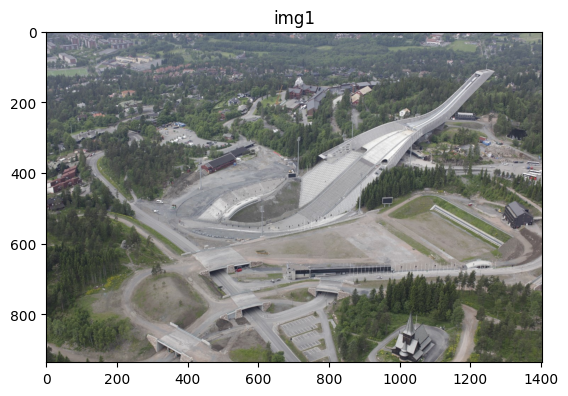

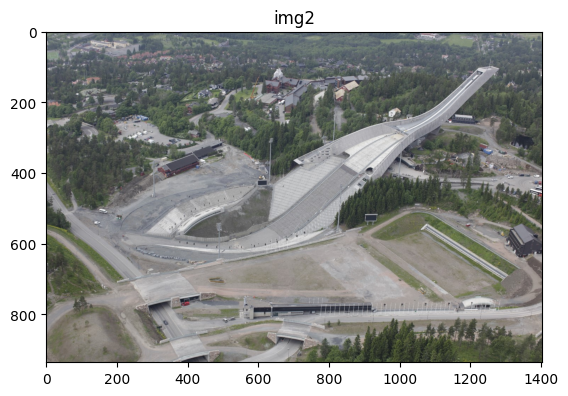

(936, 1404, 3)
(936, 1404, 3)


In [85]:
plt.figure()
plt.imshow(img1)
plt.title('img1')
plt.show()

plt.figure()
plt.imshow(img2)
plt.title('img2')
plt.show()

print(img1.shape)
print(img2.shape)

We see that these two images are the same we used in the last example at page 87 in lecture 2.
Your task is to recreate this example:
- Construct the camera calibration matrix $\mathbf{K}$
- Compute the pose of one camera relative to the other.
- Choose one or more points in one image, and compute the epipolar line in the other as a function of depth.
- Plot the epipolar lines.
- Plot a few depths along the epipolar lines.
- Plot the points at infinity.


In [86]:
from scipy.spatial.transform import Rotation

class Rot3:
    """Represents an element of the SO(3) Lie group (rotations in 3D)."""

    def __init__(self, R=np.identity(3)):
        """Constructs an SO(3) element.
        The default is the identity element.
        Other 3x3 matrices R are fitted to the closest matrix on SO(3).

        :param R: A 3x3 rotation matrix (optional).
        """
        if R is self.__init__.__defaults__[0]:
            # Default argument is identity.
            # Set property directly, since guaranteed SO(3).
            self._matrix = np.identity(3)
        else:
            # Argument should be some 3x3 matrix.
            # Fit to SO(3).
            self.matrix = R

    @property
    def matrix(self):
        """ The matrix representation of the SO(3) element

        :return: 3x3 rotation matrix corresponding to this SO(3) element.
        """
        return self._matrix

    @matrix.setter
    def matrix(self, R):
        """Sets the matrix to the closest element on SO(3)

        :param R: 3x3 matrix
        """
        # This is slower than necessary, but ensures correct representation.
        self._matrix = Rot3.to_so3_matrix(R)

    @staticmethod
    def to_so3_matrix(R):
        """Fits an arbitrary 3x3 matrix to the closest element on SO(3)

        :param R: An arbitrary 3x3 matrix
        :return: The closest valid 3x3 rotation matrix
        """
        # From Zhangs paper 
        if not (isinstance(R, np.ndarray) and R.shape == (3, 3)):
            raise TypeError('Argument must be a 3x3 matrix')

        u, s, v = np.linalg.svd(R)
        R = u.dot(v)

        if np.linalg.det(R) < 0:
            R = -R

        return R

    @classmethod
    def from_angle_axis(cls, angle, axis):
        """Construct an SO(3) element corresponding to a rotation around a specified axis.

        :param angle: Rotation angle in radians.
        :param axis: Rotation axis as a unit 3d column vector.
        :return: The SO(3) element.
        """
        # Guaranteed to be SO(3), so set property directly.
        rot3 = cls()
        rot3._matrix = Rotation.from_rotvec(angle * axis.flatten()).as_matrix()
        return rot3

    @classmethod
    def rot_x(cls, angle):
        """Construct an SO(3) element corresponding to a rotation around the x-axis.

        :param angle: Rotation angle in radians.
        :return: The SO(3) element.
        """
        return cls.from_angle_axis(angle, np.array([[1, 0, 0]]).T)

    @classmethod
    def rot_y(cls, angle):
        """Construct an SO(3) element corresponding to a rotation around the y-axis.

        :param angle: Rotation angle in radians.
        :return: The SO(3) element.
        """
        return cls.from_angle_axis(angle, np.array([[0, 1, 0]]).T)

    @classmethod
    def rot_z(cls, angle):
        """Construct an SO(3) element corresponding to a rotation around the z-axis.

        :param angle: Rotation angle in radians.
        :return: The SO(3) element.
        """
        return cls.from_angle_axis(angle, np.array([[0, 0, 1]]).T)

    @classmethod
    def from_roll_pitch_yaw(cls, roll, pitch, yaw):
        """Construct an SO(3) element from Z-Y-X Euler angles.

        :param roll: Rotation angle around the x-axis in radians.
        :param pitch: Rotation angle around the y-axis in radians.
        :param yaw: Rotation angle around the z-axis in radians.
        :return: The SO(3) element.
        """
        # Guaranteed to be SO(3) through composition, so set property directly.
        rot3 = cls()
        rot3._matrix = (Rot3.rot_z(yaw) * Rot3.rot_y(pitch) * Rot3.rot_x(roll)).matrix
        return rot3

    def compose(self, Y):
        """Compose this element with another element on the right

        :param Y: The other Rot3 element
        :return: This element composed with Y
        """
        composed_element = Rot3()
        composed_element._matrix = self.matrix.dot(Y.matrix) 
        return composed_element
    
    def inverse(self):
        """Compute the inverse of the current element X.

        :return: The inverse of the current element.
        """
        # The transpose is guaranteed to be SO(3), update the property directly.
        X_inv = Rot3()

        # TODO: Compute correct matrix for inverse!
        X_inv._matrix = self.matrix.T
        return X_inv

    def action(self, x):
        """Perform the action of the SO(3) element on the 3D column vector x.

        :param x: 3D column vector to be transformed
        :return: The resulting rotated 3D column vector
        """

        x = self.matrix.dot(x)
        return x

    def __mul__(self, other):
        """Multiplication operator performs composition on elements of SO(3) and action on vectors.

        :param other: Rot3 or 3D column vector
        :return: Composition for Rot3, or action for 3D column vector
        """
        if isinstance(other, np.ndarray) and other.shape == (3, 1):
            # Other is 3D column vector, perform action on vector.
            return self.action(other)
        elif isinstance(other, Rot3):
            # Other is Rot3, perform composition.
            return self.compose(other)
        else:
            raise TypeError('Argument must be a 3D column vector or a Rot3')

class Pose3:
    """Represents an element of the SE(3) Lie group (poses in 3D)."""

    def __init__(self, pose_tuple=(Rot3(), np.zeros((3, 1)))):
        """Constructs an SE(3) element.
        The default is the identity element.

        :param pose_tuple: A tuple (rot3, t) (optional).
        """
        self.rotation, self.translation = pose_tuple

    @property
    def rotation(self):
        """ The Rot3 rotation, an element of SO(3)

        :return: A Rot3 object corresponding to the orientation.
        """
        return self._rotation

    @rotation.setter
    def rotation(self, rot3):
        """Sets the rotation

        :param rot3: A Rot3
        """
        if not isinstance(rot3, Rot3):
            raise TypeError('Rotation must be a Rot3')

        self._rotation = rot3

    @property
    def translation(self):
        """The translation, a 3D column vector

        :return: A 3D column vector corresponding to the translation.
        """
        return self._translation

    @translation.setter
    def translation(self, t):
        """Sets the translation

        :param t: 3D column vector
        """
        if not isinstance(t, np.ndarray) and t.shape == (3, 1):
            raise TypeError('Translation must be a 3D column vector')

        self._translation = t

    def to_matrix(self):
        """Return the matrix representation of this pose.

        :return: 4x4 SE(3) matrix
        """
        T = np.identity(4)
        T[0:3, 0:3] = self.rotation.matrix
        T[0:3, 3] = self.translation.T
        return T

    def to_tuple(self):
        """Return the tuple representation of this pose

        :return: (R (3x3 matrix), t (3D column vector)
        """
        return (self.rotation.matrix, self.translation)

    def compose(self, Y):
        """Compose this element with another element on the right

        :param Y: The other Pose3 element
        :return: This element composed with Y
        """
        composed_element = Pose3()
        composed_element._rotation = self.rotation.compose(Y.rotation)
        composed_element._translation = self.translation + self.rotation.action(Y.translation)

        return composed_element

    def inverse(self):
        """Compute the inverse of the current element X.

        :return: The inverse of the current element.
        """
        inverse_pose = Pose3()
        inverse_pose._rotation = self.rotation.inverse()
        inverse_pose._translation = -inverse_pose.rotation.action(self.translation)

        return inverse_pose

    def action(self, x):
        """Perform the action of the SE(3) element on the 3D column vector x.

        :param x: 3D column vector to be transformed
        :return: The resulting rotated and translated 3D column vector
        """

        x = self.rotation.action(x) + self.translation

        return x

    def __mul__(self, other):
        """Multiplication operator performs composition on elements of SE(3) and action on vectors.

        :param other: Pose3 or 3D column vector
        :return: Composition for Pose3, or action for 3D column vector
        """
        if isinstance(other, np.ndarray) and other.shape == (3, 1):
            # Other is 3D column vector, perform action on vector.
            return self.action(other)
        elif isinstance(other, Pose3):
            # Other is Pose3, perform composition.
            return self.compose(other)
        else:
            raise TypeError('Argument must be a 3D column vector or a Pose3')

In [87]:
def skew_symmetric(v):
    """
    Returns the skew-symmetric matrix of a 3D vector.
    
    Parameters:
    v (numpy.ndarray): A 3D vector of shape (3,).
    
    Returns:
    numpy.ndarray: A 3x3 skew-symmetric matrix.
    """
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

In [88]:
def find_edge_points(line):
    a,b,c = line.flatten()
    epipolar_line = np.array([[-c/a, 0], [(-c- 936 * b)/a, 936]])
    return epipolar_line

In [89]:
K = np.array([  [f, 0, c_u],
                [0, f, c_v],
                [0, 0, 1] ])

R1, t1 = T_w_c1[:3,:3], T_w_c1[:3,3]
R2, t2 = T_w_c2[:3,:3], T_w_c2[:3,3]

Pose_w_c1 = Pose3((Rot3(R1), t1))
Pose_w_c2 = Pose3((Rot3(R2), t2))

Pose_c1_c2 = Pose_w_c1.inverse().compose(Pose_w_c2)
T_c1_c2 = Pose_c1_c2.to_matrix()

u1_c1 = np.array([ [580, 650, 1] ]).T
u2_c1 = np.array([ [1200, 650, 1] ]).T

u3_c2 = np.array([ [220, 700, 1] ]).T
u4_c2 = np.array([ [750, 850, 1] ]).T

t_1_2 = Pose_c1_c2.translation
Rot_1_2 = Pose_c1_c2.rotation.matrix
E_c1_c2 = skew_symmetric(t_1_2) @ Rot_1_2

F_c1_c2 = np.linalg.inv(K).T @ E_c1_c2 @ np.linalg.inv(K)
F_c2_c1 = F_c1_c2.T

l_c1_u3 = F_c1_c2 @ u3_c2
l_c1_u4 = F_c1_c2 @ u4_c2

l_c2_u1 = F_c2_c1 @ u1_c1
l_c2_u2 = F_c2_c1 @ u2_c1

line_c1_u3 = find_edge_points(l_c1_u3)
line_c1_u4 = find_edge_points(l_c1_u4)
line_c2_u1 = find_edge_points(l_c2_u1)
line_c2_u2 = find_edge_points(l_c2_u2)

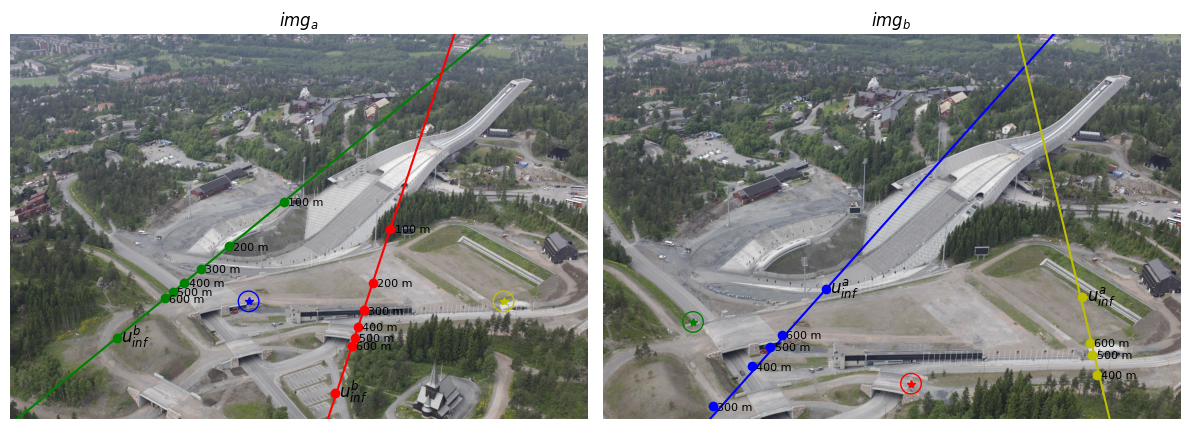

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img1)
axes[1].imshow(img2)
axes[0].axis('off')  # Hide axes
axes[1].axis('off')  # Hide axes
axes[0].set_title('$img_a$')
axes[1].set_title('$img_b$')



axes[0].plot(line_c1_u3[:, 0], line_c1_u3[:, 1], '-g')

axes[0].plot(line_c1_u4[:, 0], line_c1_u4[:, 1], '-r')

axes[1].plot(line_c2_u1[:, 0], line_c2_u1[:, 1], '-b')
axes[1].plot(line_c2_u2[:, 0], line_c2_u2[:, 1], '-y')

axes[0].plot(u1_c1[0], u1_c1[1], '*b')
axes[0].plot(u2_c1[0], u2_c1[1], '*y')

axes[1].plot(u3_c2[0], u3_c2[1], '*g')
axes[1].plot(u4_c2[0], u4_c2[1], '*r')

circle1 = Circle((u3_c2[0], u3_c2[1]), radius=25, edgecolor='g', facecolor='none')
circle2 = Circle((u4_c2[0], u4_c2[1]), radius=25, edgecolor='r', facecolor='none')
circle3 = Circle((u1_c1[0], u1_c1[1]), radius=25, edgecolor='b', facecolor='none')
circle4 = Circle((u2_c1[0], u2_c1[1]), radius=25, edgecolor='y', facecolor='none')

axes[1].add_patch(circle1)
axes[1].add_patch(circle2)
axes[0].add_patch(circle3)
axes[0].add_patch(circle4)

##########3 Infinity points

u_c1_u3_inf = K @ Rot_1_2 @ np.linalg.inv(K) @ u3_c2
u_c1_u4_inf = K @ Rot_1_2 @ np.linalg.inv(K) @ u4_c2

u_c2_u1_inf = K @ Rot_1_2.T @ np.linalg.inv(K) @ u1_c1
u_c2_u2_inf = K @ Rot_1_2.T @ np.linalg.inv(K) @ u2_c1

axes[0].plot(u_c1_u3_inf[0], u_c1_u3_inf[1], 'og')
axes[0].text(u_c1_u3_inf[0] + 10, u_c1_u3_inf[1] + 10, '$u^b_{inf}$', fontsize=12, color='black')
# add text $u^3_inf$
axes[0].plot(u_c1_u4_inf[0], u_c1_u4_inf[1], 'or')
axes[0].text(u_c1_u4_inf[0] + 10, u_c1_u4_inf[1] + 10, '$u^b_{inf}$', fontsize=12, color='black')

axes[1].plot(u_c2_u1_inf[0], u_c2_u1_inf[1], 'ob')
axes[1].text(u_c2_u1_inf[0] + 10, u_c2_u1_inf[1] + 10, '$u^a_{inf}$', fontsize=12, color='black')
axes[1].plot(u_c2_u2_inf[0], u_c2_u2_inf[1], 'oy')
axes[1].text(u_c2_u2_inf[0] + 10, u_c2_u2_inf[1] + 10, '$u^a_{inf}$', fontsize=12, color='black')

for i in range(100, 601, 100):

    point = u_c1_u3_inf.flatten() + 1.0/i * (K @ t_1_2).flatten() 
    point = point[:2] / point[2]
    axes[0].plot(point[0], point[1], 'og')
    axes[0].text(point[0] + 10, point[1] + 10, f'{i} m', fontsize=8, color='black')

for i in range(100, 601, 100):

    point = u_c1_u4_inf.flatten() + 1.0/i * (K @ t_1_2).flatten() 
    point = point[:2] / point[2]
    axes[0].plot(point[0], point[1], 'or')
    axes[0].text(point[0] + 10, point[1] + 10, f'{i} m', fontsize=8, color='black')

for i in range(300, 601, 100):

    point = u_c2_u1_inf.flatten() - 1.0/i * (K @ t_1_2).flatten() 
    point = point[:2] / point[2]
    axes[1].plot(point[0], point[1], 'ob')
    axes[1].text(point[0] + 10, point[1] + 10, f'{i} m', fontsize=8, color='black')

for i in range(400, 601, 100):

    point = u_c2_u2_inf.flatten() - 1.0/i * (K @ t_1_2).flatten() 
    point = point[:2] / point[2]
    axes[1].plot(point[0], point[1], 'oy')
    axes[1].text(point[0] + 10, point[1] + 10, f'{i} m', fontsize=8, color='black')

axes[0].set_xlim(0, img1.shape[1])
axes[0].set_ylim(img1.shape[0], 0)
axes[1].set_xlim(0, img2.shape[1])
axes[1].set_ylim(img2.shape[0], 0)

plt.tight_layout()
plt.show()

Feel free to play around!